<a href="https://colab.research.google.com/github/nomnomnonono/Image-Completion/blob/main/GLCIC/calculate_fid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Dec 19 05:47:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## ライブラリの読み込み

In [24]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/experiment/final")

In [70]:
import torch
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torchvision.utils import save_image

import json
import joblib
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

from datasets import ImageDataset
from fid import fid_torch, fid_pil, fid_cv
from models import CompletionNetwork
from utils import sample_random_batch, generate_mask, define_hole_area, get_completion_image

## 初期設定

In [29]:
data_dir = "img_align_celeba"
result_dir = "/content/drive/MyDrive/Colab Notebooks/experiment/final/result"
device = torch.device('cuda')
bsize = 32
cn_input_size = 120

model_cn = CompletionNetwork().to(device)

## 画像の読み込み

In [9]:
!mkdir train test

In [10]:
!cp "/content/drive/MyDrive/Colab Notebooks/experiment/final/img_align_celeba.zip" "."
!unzip -q img_align_celeba.zip
!mv img_align_celeba/2* test/

In [11]:
!ls "img_align_celeba" -1 | wc -l
!ls "test" -1 | wc -l

199999
2600


## mpvの読み込み

In [12]:
mpv_json = open(os.path.join(result_dir, 'config.json'), 'r')
mpv_data = json.load(mpv_json)
mpv = mpv_data['mpv']
mpv = np.array(mpv)

In [13]:
mpv = torch.tensor(mpv.reshape(1, 3, 1, 1), dtype=torch.float32).to(device)

## データセット

In [14]:
transform = transforms.Compose([
        transforms.Resize(cn_input_size),
        transforms.RandomCrop((cn_input_size, cn_input_size)),
        transforms.ToTensor(),
])

train = ImageDataset('img_align_celeba', transform)
train_loader = DataLoader(train, batch_size=bsize, shuffle=True)
test = ImageDataset('test', transform)

## Inception v3の読み込み

In [15]:
model = models.inception_v3(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [16]:
model.dropout = torch.nn.Identity()
model.fc = torch.nn.Identity()

In [17]:
torchsummary.summary(model, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [18]:
model = model.eval()

## 実行

In [21]:
with torch.no_grad():
  x = sample_random_batch(test, batch_size=bsize).to(device)
  mask = generate_mask((bsize, 1, 120, 120), hole_size=((36,72),(36,72)),
                       hole_area=define_hole_area((72,72),(120,120))[0]).to(device)
  x_mask = x - x*mask + mpv*mask
  x_in = torch.cat((x_mask, mask), dim=1)

### step1 bicubic

In [31]:
cv_score1 = []
pil_score1 = []
torch_score1 = []

pbar = tqdm(total=9)
for i in range(1, 10):  
  cn_path = os.path.join(result_dir, 'phase_1', 'step{}.pth'.format(10000*i))
  model_cn.load_state_dict(torch.load(cn_path, map_location='cpu'))
  model_cn.eval()
  with torch.no_grad():
    x_out = model_cn(x_in)
    x_inpaint = get_completion_image(x, x_out, mask).to(device)
    cv1 = fid_cv(model, x, x_inpaint, device)
    pil1 = fid_pil(model, x, x_inpaint, device)
    torch1 = fid_torch(model, x, x_inpaint, device)
  cv_score1.append(cv1)
  pil_score1.append(pil1)
  torch_score1.append(torch1)
  pbar.update()

  0%|          | 0/9 [00:29<?, ?it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 9/9 [05:57<00:00, 39.58s/it]

In [75]:
ax = np.arange(10000, 100000, 10000)

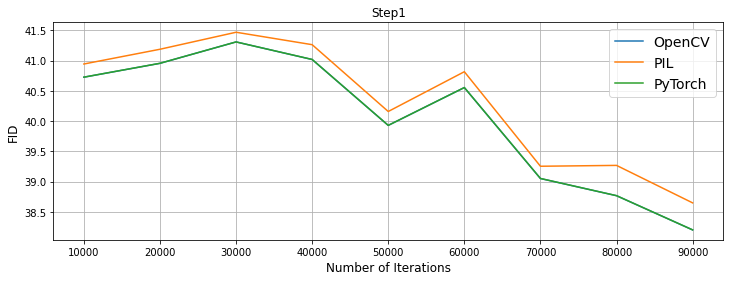

In [98]:
fig = plt.figure(figsize=(12, 4))
plt.plot(ax, cv_score1, label='OpenCV')
plt.plot(ax, pil_score1, label='PIL')
plt.plot(ax, torch_score1, label='PyTorch')
plt.grid()
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('Step1', fontsize=12)
plt.legend(fontsize=14)
fig.savefig(os.path.join(result_dir, 'phase_1', 'fid.png'))

In [71]:
joblib.dump(cv_score1, os.path.join(result_dir, 'phase_1', 'fid_cv.txt'))
joblib.dump(pil_score1, os.path.join(result_dir, 'phase_1', 'fid_pil.txt'))
joblib.dump(torch_score1, os.path.join(result_dir, 'phase_1', 'fid_torch.txt'))

['/content/drive/MyDrive/Colab Notebooks/experiment/final/result/phase_1/fid_torch.txt']

### step3: bicubic

In [104]:
cv_score3 = [cv1]
pil_score3 = [pil1]
torch_score3 = [torch1]

pbar = tqdm(total=50)
for i in range(1, 51):  
  cn_path = os.path.join(result_dir, 'phase_3', 'cn_step{}.pth'.format(10000*i))
  model_cn.load_state_dict(torch.load(cn_path, map_location='cpu'))
  model_cn.eval()
  with torch.no_grad():
    x_out = model_cn(x_in)
    x_inpaint = get_completion_image(x, x_out, mask).to(device)
    cv3 = fid_cv(model, x, x_inpaint, device)
    pil3 = fid_pil(model, x, x_inpaint, device)
    torch3 = fid_torch(model, x, x_inpaint, device)
  cv_score3.append(cv3)
  pil_score3.append(pil3)
  torch_score3.append(torch3)
  pbar.update()

  0%|          | 0/50 [00:19<?, ?it/s]
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
100%|██████████| 50/50 [33:31<00:00, 40.39s/it]

In [105]:
ax = np.arange(0, 510000, 10000)

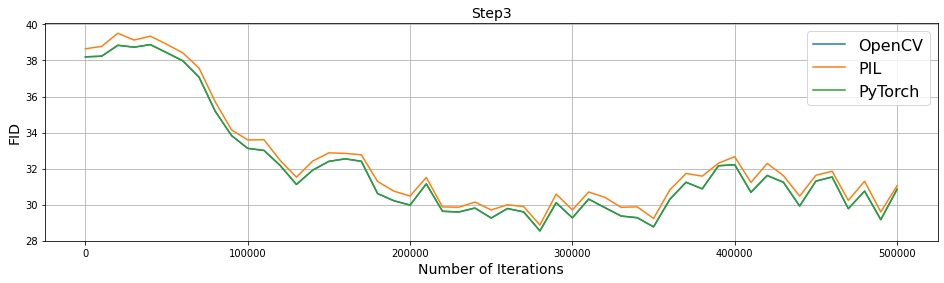

In [112]:
fig = plt.figure(figsize=(16, 4))
plt.plot(ax, cv_score3, label='OpenCV')
plt.plot(ax, pil_score3, label='PIL')
plt.plot(ax, torch_score3, label='PyTorch')
plt.grid()
plt.xlabel('Number of Iterations', fontsize=14)
plt.ylabel('FID', fontsize=14)
plt.title('Step3', fontsize=14)
plt.legend(fontsize=16)
fig.savefig(os.path.join(result_dir, 'phase_3', 'fid.png'))

In [113]:
joblib.dump(cv_score3, os.path.join(result_dir, 'phase_3', 'fid_cv.txt'))
joblib.dump(pil_score3, os.path.join(result_dir, 'phase_3', 'fid_pil.txt'))
joblib.dump(torch_score3, os.path.join(result_dir, 'phase_3', 'fid_torch.txt'))

['/content/drive/MyDrive/Colab Notebooks/experiment/final/result/phase_3/fid_torch.txt']